# Pocket Planet


#### Authors:
v1.0 (2020 Spring) Alexander Khazatsky, William Gan, Kannan Ramchandran

## Introduction

In this lab, we'll be studying Interactive Particle Systems (IPS). IPS is a good model for understanding the behaviour of agents in a world and can be viewed as an extension of Markov chains. In a Markov chain, the key is the Markov property, which tells us that the next time step only depends on our current state. This is true in an IPS model as well.

To be more concrete, in this lab, we'll try to understand how biological evolution is affected by things such as the rate of mutations, the environment, etc. To do so, we'll setup a world and treat organisms as particles. At each step, these organisms may reproduce, compete each with other, etc.  

<!-- ![cover%20photo.png](attachment:cover%20photo.png) -->

In [1]:
from pocket_planet_utils import *

## Part 1: Perlin Noise

Before, we setup our IPS model, however, first we'll create our world. But, how do we generate elevations that look realistic? A lot of research has been poured into this, and one method which has been successful is Perlin noise [(Wikipedia)](https://en.wikipedia.org/wiki/Perlin_noise) [(Blog)](https://flafla2.github.io/2014/08/09/perlinnoise.html). It is used in both animated movies and Minecraft, and in this portion, we'll see how to implement it. Below you will find perlin noise in 1, 2, and 3 dimensions.

<div>
  <table>
    <tr>
      <td>
        <img src="images/perlin_noise.png", width=875px>
      </td>
    </tr>
 </table>
</div>


We will design our world to be a 100 pixel by 100 pixel square with 7 terrains: ocean, shallows, sand, dirt, inland, mountain, and snow. Each terrain will corresponds to an elevation range, and so to generate our world, we just need to generate 2D perlin noise to use for our elevations. The following pictures show what the elevations and worlds should end up looking like.

<div>
  <table>
    <tr>
      <td>
        <img src="images/elevations.png">
      </td>
      <td>
        <img src="images/uninhabited.png">      
      </td>
    </tr>
  </table>
</div>

Now, to generate the functions of each frequency, we create a $(l+1) \times (l+1)$ array of unit gradient vectors (kind of like what is shown on the left), where $l$ is the maximum frequency (in the above picture, it is 128). Each square in this grid has 4 gradient vectors on the corner, as shown on the right.

<div>
  <table>
    <tr>
      <td>
        <img src="images/perlin_gradients.png">
      </td>
      <td>
        <img src="images/perlin_grad_4.png">
      </td>
    </tr>
 </table>
</div>

**Question 1a**. In the cell below, **generate n-dimensional gradient vectors with unit length**. Each gradient vector is computed by sampling from $\mathcal{N}(0, I_n)$, and then normalizing it to be unit length.

In [2]:
def generate_gradient(n):
    # START YOUR MAGNIFICENT CODE HERE
    gradient = np.random.randn(n)
    # END YOUR MAGNIFICENT CODE HERE
    return gradient / np.linalg.norm(gradient)

**Question 1b**. In the cell below, **generate the array of gradients** for the 2D case as a NumPy array with shape $(l+1, l+1, 2)$.

In [7]:
def generate_corner_gradients(l):
    # START YOUR MAGNIFICENT CODE HERE
    corners = np.array([[generate_gradient(2) for i in range(l + 1)] for _ in range(l + 1)])
    # END YOUR MAGNIFICENT CODE HERE
    return corners

Now comes the interpolation part. For a general point in $[0, l] \times [0, l]$, find which square it lies by looking at the floor and ceiling of its x and y coordinates. Then, fill in the code to compute the dot product of the gradient vector and "delta" vector for each of the 4 corners of the square it lies in. The "delta" vectors for a point in one of the $l \times l$ squares is shown below.

<div>
  <table>
    <tr>
      <td>
        <img src="images/perlin_dist_4.png">
      </td>
    </tr>
 </table>
</div>

**Question 1c**. In the cell below, given the $(l+1) \times (l+1)$ array of gradients and a point whose coordinates lie in $[0, l] \times [0, l]$, fill in the code to **compute the 4 dot products** as a $2 \times 2$ NumPy array. **Make sure your in your result, the [0,0] entry corresponds to the top left corner, the [1, 0] entry corresponds to the bottom left corner, etc.**

In [13]:
def compute_dot_products(gradients, x, y):
    # START YOUR MAGNIFICENT CODE HERE
    floor_x, floor_y = int(x), int(y) # coordinates rounded down
    ceil_x, ceil_y = floor_x + 1, floor_y + 1 # coordinates rounded up
    corner_coords = np.array([[[floor_x, floor_y], [ceil_x, floor_y]], [[floor_x, ceil_y], [ceil_x, ceil_y]]]) # numpy array of corner coordinates with shape (2,2,2)
    # END YOUR MAGNIFICENT CODE HERE
    corner_gradients = gradients[floor_y: ceil_y+1, floor_x: ceil_x+1]
    delta = np.array([x, y]) - corner_coords
    return np.sum(corner_gradients * delta, axis=2)

Now we want to interpolate a value at (x, y) given the values at the 4 corners. It turns out a nice function for doing this involves a degree-5 polynomial.

In [14]:
def smooth_interp(t, a, b):
    smooth_t = 6*t**5 - 15*t**4 + 10*t**3
    return (1 - smooth_t) * a + smooth_t * b

Bilinearly interpolate.

In [15]:
def interpolate(dots, x, y):
    dx = x - np.floor(x)
    dy = y - np.floor(y)
    interp1 = smooth_interp(dx, dots[0, 0], dots[0, 1])
    interp2 = smooth_interp(dx, dots[1, 0], dots[1, 1])
    interp = smooth_interp(dy, interp1, interp2)
    return interp

Now to put everything together, even though our array of gradients corresponds to a point in $[0, l] \times [0, l]$, each pixel in our 100 x 100 square world will just correspond to a point $[0, 1] \times [0, 1]$. However, we will still use the rest of the array as we will generate the higher frequency functions by mapping a point $x, y \in [0, 1] \times [0, 1]$ to $f \cdot x, f \cdot y \in [0, l] \times [0, l]$, where $f$ is the frequency.

In [16]:
def generate_world(size=100, l=4):
    grad = generate_corner_gradients(2 ** l + 1)
    units = np.linspace(0, 1, size)
    rescale_factor = (2 ** 0.5)
    grid = np.zeros((size, size))
    for i, x in enumerate(units):
        for j, y in enumerate(units):
            for log_f in range(l):
                f = 2 ** log_f
                amp = 1 / f
                new_x = x * f
                new_y = y * f
                dots = compute_dot_products(grad, new_x, new_y)
                val = interpolate(dots, new_x, new_y)
                rescaled_val = val * rescale_factor
                grid[j][i] += rescaled_val * amp
    grid /= 2 - 2 ** (1 - l)        
    return grid

You may have to run this cell and the cell below several times to get the world you want.

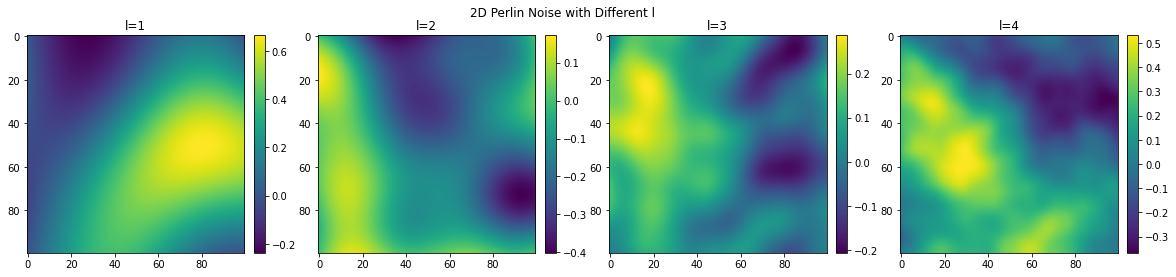

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
test_worlds = []
fig.suptitle('2D Perlin Noise with Different l')
for l in range(4):
    world = generate_world(l=l+1)
    test_worlds.append(world)
    ax[l].set_title(f'l={l+1}')
    im = ax[l].imshow(world)
    fig.colorbar(im, ax=ax[l], fraction=0.046, pad=0.04)

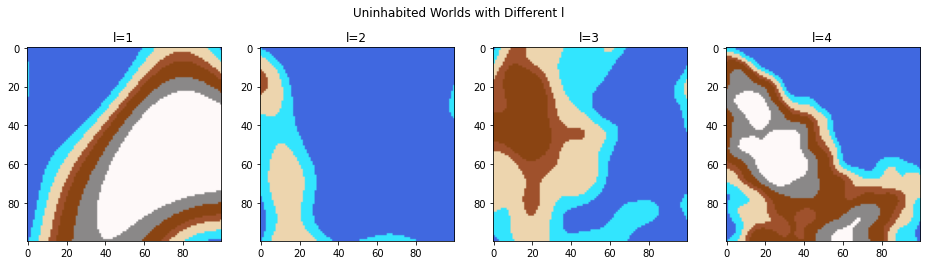

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Uninhabited Worlds with Different l')
for l in range(4):
    uninhabited_world = get_uninhabited_world(test_worlds[l])
    ax[l].set_title(f'l={l+1}')
    im = ax[l].imshow(uninhabited_world)

Use the knobs below to visualize worlds with defined height vectors for the enviorment types.

In [19]:
grid = generate_world()

@interact(ocean=h_o,shallows=h,beach=h,dirt=h,inland=h,mountain=h)
def toggle_ground_heights(ocean=0.01,
                          shallows=0.075,
                          beach=0.15,
                          dirt=0.2,
                          inland=0.3,
                          mountain=0.4,):
    heights = np.array([ocean, shallows, beach, dirt, inland, mountain, 1])
    visualize_height_values(heights, grid)

interactive(children=(FloatSlider(value=0.01, description='ocean', max=0.5, step=0.05), FloatSlider(value=0.07…

## Part 2: Bringing Particles To Life

Now that we have our planet, we can set up our IPS system. The idea is our particles will be able to move around on our 100 x 100 grid, but first, we need to define the state of a particle. For this lab, we'll assume all organisms are trees. Each tree has DNA, which is a convex combination of $k$ archetypes, where $k$ is the number of inhabitable environment types on our planet. Note that this means the elements of our DNA vector must be nonnegative and sum to 1. You will find the inhabitable environment types, and their corresponding ideal tree below:


<div>
  <table>
    <tr>
      <td>
        <img src="images/plant_land_table.png", width=400px>    
      </td>
    </tr>
  </table>
</div>

So, for example, a DNA of $[0.05, 0.05, 0.05, 0.8, 0.05]$ will be a tree well suited to live in the Inland environment.

- Initially, a tree's DNA will be generated by sampling a vector from $\lvert \mathcal{N}(0, I_k) \rvert$ , and then dividing it by its sum.
- Each time step, a tree may have offspring (seeds) whose DNA will be slightly mutated. The offspring's DNA will be generated by sampling from $\lvert \mathcal{N}(\text{parent DNA}, \sigma_{\text{mutation}}^2) \rvert$, and then dividing this vector by its sum. So the current DNA, say $[0.05, 0.05, 0.05, 0.8, 0.05]$ again, will be used as the mean for the multivariate normal distribution, and then after taking the absolute value + renormalizing, we may end up with something like $[0.03, 0.06, 0.06, 0.78, 0.07]$.

**Question 2a**. In the following cell, fill out the functions for generating the initial random DNA as well as generating offspring.

In [21]:
class Tree(AbstractTree):

    def initialize_random_dna(self, k):
        # START YOUR MAGNIFICENT CODE HERE
        dna = np.abs(np.random.randn(k))
        dna /= np.sum(dna)
        # END YOUR MAGNIFICENT CODE HERE
        self.dna = dna
    
    def generate_offspring(self, mutation_var):
        # START YOUR MAGNIFICENT CODE HERE
        offspring_dna = np.abs(np.random.normal(self.dna, mutation_var**0.5))
        offspring_dna /= np.sum(offspring_dna)
        # END YOUR MAGNIFICENT CODE HERE
        return Tree(dna=offspring_dna)  

Visualize DNA.

In [22]:
@interact(x_1=r,x_2=r,x_3=r,x_4=r,x_5=r)
def f(x_1,x_2,x_3,x_4,x_5):
    unnormalized_DNA = np.array([x_1,x_2,x_3,x_4,x_5])
    DNA = unnormalized_DNA / np.sum(unnormalized_DNA)
    tree = Tree(DNA)
    visualize_dna(tree)

interactive(children=(FloatSlider(value=0.5, description='x_1', max=1.0), FloatSlider(value=0.5, description='…

Visualize mutations over multiple generations of a tree's DNA. Feel free to play with the variance and see how things change.

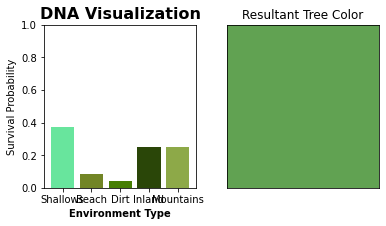

In [24]:
tree = Tree()
var = 0.001
for i in range(20):
    clear_output(wait=True)
    visualize_dna(tree)
    tree = tree.generate_offspring(var)

## Part 3: Defining The Mechanics

Now that we have our particles (AKA our trees), we can define the mechanics that govern them.

- Our world will initially be empty, but at each time step, a tree can magically appear in a square with probability `self.life_prob`. This will be done in `simulate_life_creation`.
- Given a tree is currently in a square, it survives each time step with some probability (`age_tree`).
- Given it survives, it can then also generate a number of offspring ~ $Binom(self.max\_seeds, fitness)$, handled in (`generate_offspring`).
- Finally, if a bunch of offspring (seeds) are on a square in our world, they will need to participate in a stochastic competition for the square. Because we want trees with higher fitnesses to have a higher probability of winning, we will sample the victor from the Boltzmann distribution. Implement the Boltzmann distribution as follows:
  - $energy[i] = exp(self.comp\_constant * fitness[i])$
  - $P[winner=i] := \frac{energy[i]}{sum(energy)}$

**Question 3a**. Fill out the following class.

In [27]:
class Square(AbstractSquare):
    
    def simulate_life_creation(self):
        # START YOUR MAGNIFICENT CODE HERE
        p = np.random.rand() < self.life_prob
        # END YOUR MAGNIFICENT CODE HERE
        if p: self.plant_seed(Tree())
            
    def age_tree(self):
        if not self.contains_tree():
            return
        survival_prob = self.tree.calc_fitness(self.env_type)
        
        # START YOUR MAGNIFICENT CODE HERE
        p = np.random.rand() > survival_prob
        # END YOUR MAGNIFICENT CODE HERE
        
        if p: self.terminate_tree()
            

    def generate_offspring(self):
        if not self.contains_tree():
            return []
        fitness = self.tree.calc_fitness(self.env_type)
        
        # START YOUR MAGNIFICENT CODE HERE
        num_offspring = np.random.binomial(self.max_seeds, fitness)
        # END YOUR MAGNIFICENT CODE HERE
        
        offspring = [self.tree.generate_offspring(self.mutation_var)
                    for i in range(num_offspring)]
        return offspring
    
    
    def sample_boltzmann_distribution(self, fitness, return_dist=False):
        # START YOUR MAGNIFICENT CODE HERE
        energy = np.exp(self.comp_constant * fitness)
        probabilities = energy / np.sum(energy)
        # END YOUR MAGNIFICENT CODE HERE

        if return_dist:
            return probabilities
        winner_index = random.choices(np.arange(0, len(fitness)), probabilities)[0]
        return winner_index

**Question 3b**. We can now visualize evolution for a single square in our world. Based on your investigations, answer the following questions:

1. What would you guess is the environment type of the square?
2. How does mutation variance affect convergence?
3. In a rapidly changing environment, would we want a high or low mutation rate? What about in a predictable environment?
4. How does the competition constant affect convergence?

ANSWERS HERE
1. Dirt
2. The smaller the mutation variance is, the stabler it converges.
3. changing environment -> high mutation rate and vice versa.
4. The bigger the comp_constant is, the quicker it converges.

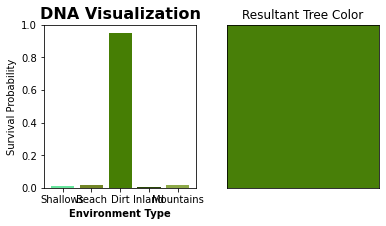

In [36]:
var = 0.001
comp_constant = 100
    
square = create_secret_square(var, comp_constant, Square)

for i in range(50):
    plt.pause(0.1)
    clear_output(wait=True)
    psuedo_env_step(square, Tree)

### Visualizing Competitions

Next we will visualize a competition amongst multiple trees for a single square, and study the effects the competition constant has on the outcome.

**Question 3c.** Based off the visualizer below, what effect does the competition constant have on the entropy of the distribution?

*Fun Fact: This concept is the key to a state-of-the-art Reinforcement Learning algorithm called Soft Actor Critic, which uses this property to address something called the exploration-exploitation tradeoff.

ANSWERS HERE

In [37]:
@interact(const=(0, 10, 0.5))
def visualize_fitness_competition(const=0):
    square = create_secret_square(var, const, Square)
    dist = square.sample_boltzmann_distribution(np.array(example_fitness),
                                               return_dist=True)
    
    visualize_competition(dist, entropy(dist))

interactive(children=(FloatSlider(value=0.0, description='const', max=10.0, step=0.5), Output()), _dom_classes…

## Q4 Bringing It All Together

You're almost done! All that's left is to make our particles be able to move across squares.

- In `simulate_movement`, we want to be able to move a particle from position i, j.  To do this, we'll sample new_coord ~ N([i,j], var), then clip to [min_val, max_val], and finally round to the nearest integer.
- In `spread_seeds`, we'll get new positions for a seeds at (i, j) by setting the variance for `simulate_movement`. If a square is an ocean, set variance to be self.waves_var. Otherwise, set it to be self.wind_var.

In [38]:
class World(AbstractWorld):
    def simulate_movement(self, i, j, var):
        coord = np.array([i, j])
        min_val, max_val = 0, self.dim - 1
        
        # START YOUR MAGNIFICENT CODE HERE
        unclipped_coord = np.random.normal(coord, var**0.5)
        new_coord = np.clip(unclipped_coord, a_min=min_val,a_max=max_val)
        new_coord = np.round_(new_coord).astype('int64')
        # END YOUR MAGNIFICENT CODE HERE
        #Note: make sure the elements of new_coord are integers
        
        return new_coord[0], new_coord[1]
    
    def spread_seeds(self, i, j):
        square = self.world[i][j]
        trees = square.get_seeds()
        
        if square.is_ocean():
            var = self.waves_var
        else:
            var = self.wind_var
            
        for tree in trees:
            x, y = self.simulate_movement(i, j, var)
            self.world[x][y].plant_seed(tree)

## Congratulations!

You're free! We hope you've enjoyed this evolutionary journey. We highly recommend tinkering with the hyperparameters. After putting in all this work, you might as well get some fun out of it. If you find any cool properties, feel free to write about it below!

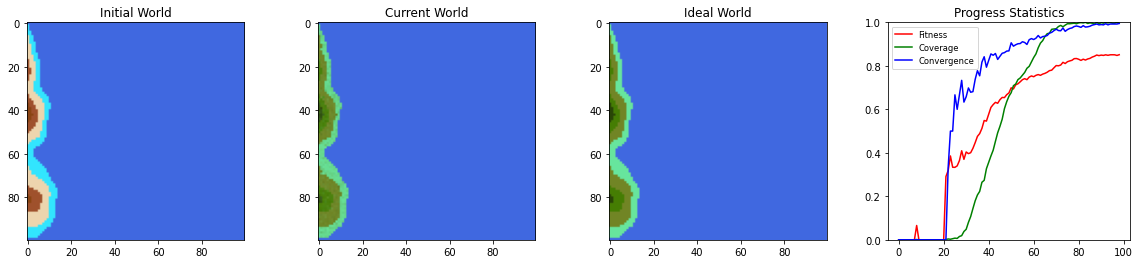

In [40]:
world = World(generate_world,
              Square,
              dim=100,
              mutation_var=0.01,
              comp_constant=100,
              wind_var=2,
              waves_var=5,
              max_seeds=5)

for i in range(100):
    world.env_step()

**Question 4a**. When life initially starts to spread accross the map, the fitness curve is extremely volatile, but eventually it smooths out. Why is this?

ANSWERS HERE

**Question 4b**. You might notice that the Coverage progression curve tends to match a sigmoid curve. Give a theory as to why this might be.

ANSWERS HERE

## References

1. https://en.wikipedia.org/wiki/Perlin_noise
1. https://flafla2.github.io/2014/08/09/perlinnoise.html
1. https://gamedev.stackexchange.com/questions/23625/how-do-you-generate-tileable-perlin-noise